In [1]:
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import argparse
import json

In [2]:
# model.predict(env.reset()[None, :])
# obs.shape
# data[e]['cloned_behavior'].predict(env.reset()[None, :])

In [3]:
def execute_expert_policy(policy_fn, envname, max_timesteps, num_rollouts):

    with tf.Session():
        tf_util.initialize()

        env = gym.make(envname)
        max_steps = max_timesteps or env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(num_rollouts):
            print('rollout_num', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = policy_fn(obs[None, :])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                if steps % 100 == 0:
                    print("%i/%i" % (steps, max_steps))
                if steps >= max_steps:
                    break
            returns.append(totalr)
        data = {
            'observations': np.array(observations),
            'actions': np.array(actions)
        }
        return returns, data
    
def execute_cloned_policy(policy_fn, envname, max_timesteps, num_rollouts):
    env = gym.make(envname)
    max_steps = max_timesteps or env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(num_rollouts):
        print('rollout_num', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = policy_fn(obs[None, :])
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1
            if steps % 100 == 0:
                print("%i/%i" % (steps, max_steps))
            if steps >= max_steps:
                break
        returns.append(totalr)
    data = {
        'observations': np.array(observations),
        'actions': np.array(actions)
    }
    return returns, data

# Behavior Cloning

In [4]:
import os
import pickle

envs = os.listdir('./data/')

data = {}
for e in envs:
    data[e] = pickle.load(open(os.path.join('data', e), 'rb'))

In [5]:
# clone the behavior
from keras.models import Sequential
from keras.layers import Dense, Activation

for e in envs:
    d = data[e]
    obs = d['observations']
    act = d['actions']
    model = Sequential()
    model.add(Dense(input_dim=obs.shape[-1], output_dim=100))
    model.add(Activation('relu'))
    model.add(Dense(output_dim=act.shape[-1]))
#     model.add(Activation('softmax'))

    model.compile(loss='mean_squared_error',
                  optimizer='adam')
    model.fit(obs.squeeze(), act.squeeze(), nb_epoch=30, batch_size=32)
    data[e]['cloned_behavior'] = model

Using TensorFlow backend.


Epoch 1/30
20000/20000 [==============================] - 2s - loss: 0.0442     
Epoch 2/30
20000/20000 [==============================] - 3s - loss: 0.0114     
Epoch 3/30
20000/20000 [==============================] - 4s - loss: 0.0082     
Epoch 4/30
20000/20000 [==============================] - 4s - loss: 0.0066     
Epoch 5/30
20000/20000 [==============================] - 4s - loss: 0.0056     
Epoch 6/30
20000/20000 [==============================] - 4s - loss: 0.0048     
Epoch 7/30
20000/20000 [==============================] - 3s - loss: 0.0041     
Epoch 8/30
20000/20000 [==============================] - 4s - loss: 0.0037     
Epoch 9/30
20000/20000 [==============================] - 4s - loss: 0.0032     
Epoch 10/30
20000/20000 [==============================] - 4s - loss: 0.0029     
Epoch 11/30
20000/20000 [==============================] - 4s - loss: 0.0027     
Epoch 12/30
20000/20000 [==============================] - 3s - loss: 0.0026     
Epoch 13/30
20000/20000 [

In [6]:
# run the expert and the cloned models, to get stats
for e in envs:
    expert_policy_file = os.path.join('experts', e)
    policy_fn = load_policy.load_policy(expert_policy_file)
    cloned_fn = lambda x: data[e]['cloned_behavior'].predict(x)

    envname = e.split('.')[0]
    max_timesteps = None
    num_rollouts = 3
    reward_expert, _ = execute_expert_policy(policy_fn, envname, max_timesteps, num_rollouts)
    reward_cloned, _ = execute_cloned_policy(cloned_fn, envname, max_timesteps, num_rollouts)
    data[e]['expert_stats'] = reward_expert
    data[e]['cloned_stats'] = reward_cloned

obs (1, 111) (1, 111)
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:42:41,644] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:42:41,647] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:42:43,228] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:42:50,794] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
obs (1, 17) (1, 17)
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:42:56,441] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:42:56,444] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:42:57,995] Making new env: HalfCheetah-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:43:00,353] Making new env: HalfCheetah-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
obs (1, 376) (1, 376)
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:43:03,378] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:43:03,381] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:43:05,152] Making new env: Humanoid-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:43:12,356] Making new env: Humanoid-v1


1000/1000
rollout_num 0
rollout_num 1
rollout_num 2
obs (1, 11) (1, 11)
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:43:13,085] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:43:13,088] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:43:14,660] Making new env: Reacher-v1
[2017-06-24 16:43:14,879] Making new env: Reacher-v1


rollout_num 0
rollout_num 1
rollout_num 2
rollout_num 0
rollout_num 1
rollout_num 2
obs (1, 17) (1, 17)
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:43:15,210] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:43:15,213] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:43:16,977] Making new env: Walker2d-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:43:20,267] Making new env: Walker2d-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000


In [7]:
# make some plots for each env

for e in data:
    print(e)
    cloned = data[e]['cloned_stats']
    expert = data[e]['expert_stats']
    print('Cloned mean: {}, std: {}'.format(np.mean(cloned).round(), np.std(cloned).round()))
    print('Expert mean: {}, std: {}'.format(np.mean(expert).round(), np.std(expert).round()))
    print('--------')


Reacher-v1.pkl
Cloned mean: -9.0, std: 5.0
Expert mean: -6.0, std: 1.0
--------
Walker2d-v1.pkl
Cloned mean: 3419.0, std: 2215.0
Expert mean: 5515.0, std: 62.0
--------
HalfCheetah-v1.pkl
Cloned mean: 4028.0, std: 26.0
Expert mean: 4090.0, std: 37.0
--------
Ant-v1.pkl
Cloned mean: 4095.0, std: 908.0
Expert mean: 4867.0, std: 80.0
--------
Humanoid-v1.pkl
Cloned mean: 388.0, std: 86.0
Expert mean: 10421.0, std: 36.0
--------


# Dagger

In [8]:
e = 'Ant-v1.pkl'
d = data[e]
obs = d['observations']
act = d['actions']
num_dagger_iterations = 20
envname = e.split('.')[0]
policy_fn = load_policy.load_policy('./experts/{}.pkl'.format(envname))
max_timesteps = None
num_rollouts = 3

# models
cloning = Sequential()
cloning.add(Dense(input_dim=obs.shape[-1], output_dim=50))
cloning.add(Activation('relu'))
cloning.add(Dense(output_dim=act.shape[-1]))
cloning.compile(loss='mse',
              optimizer='adam')
dagger = Sequential()
dagger.add(Dense(input_dim=obs.shape[-1], output_dim=50))
dagger.add(Activation('relu'))
dagger.add(Dense(output_dim=act.shape[-1]))
dagger.compile(loss='mse',
              optimizer='adam')

# execute dagger
reward_exp, data_union = execute_expert_policy(policy_fn, envname, max_timesteps, num_rollouts)
data_cloning = data_union
stats = []
for i in (range(num_dagger_iterations)):
    # train policy on data
    data_cloning['observations'] = (data_cloning['observations'] - data_cloning['observations'].mean()) / data_cloning['observations'].std()
    data_union['observations'] = (data_union['observations'] - data_union['observations'].mean()) / data_union['observations'].std()
    cloning.fit(data_cloning['observations'].squeeze(),
                data_cloning['actions'].squeeze(), nb_epoch=1, batch_size=32)
    dagger.fit(data_union['observations'].squeeze(),
                data_union['actions'].squeeze(), nb_epoch=1, batch_size=32)

    # run policy on a rollout
    dagger_fn = lambda x: dagger.predict(x)
    cloned_fn = lambda x: cloning.predict(x)
    _, data_dagger = execute_cloned_policy(dagger_fn, envname, max_timesteps, num_rollouts)
    
    # log some stats
    reward_dag, _ = execute_cloned_policy(dagger_fn, envname, max_timesteps, 2)
    reward_cloned, _ = execute_cloned_policy(cloned_fn, envname, max_timesteps, 2)
    reward_exp, _ = execute_expert_policy(policy_fn, envname, max_timesteps, 2)
    stats.append({
            'dagr_mean': np.mean(reward_dag),
            'dagr_std': np.std(reward_dag),
            'cloner_mean': np.mean(reward_cloned),
            'cloner_std': np.std(reward_cloned),
            'expr_mean': np.mean(reward_exp),
            'expr_std': np.std(reward_exp)
        })
    
    # label policy with expert
    obs = data_dagger['observations']
    with tf.Session():
        tf_util.initialize()
        data_dagger['actions'] = policy_fn(obs).squeeze()

    # union the data
#     data_union['actions'] = np.concatenate(
#         [data_dagger['actions'], data_union['actions'].squeeze()])
#     data_union['observations'] = np.concatenate(
#         [data_dagger['observations'], data_union['observations']])
    data_union = data_dagger

    # the cloning should only get expert actions
    _, data_cloning2 = execute_expert_policy(
        policy_fn, envname, max_timesteps=data_dagger['actions'].shape[0], num_rollouts=num_rollouts)
#     data_cloning['actions'] = np.concatenate(
#         [data_cloning['actions'], data_cloning2['actions'].squeeze()])
#     data_cloning['observations'] = np.concatenate(
#         [data_cloning['observations'], data_cloning2['observations']])
    data_cloning = data_cloning2


obs (1, 111) (1, 111)
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:43:23,932] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:43:23,935] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:43:25,947] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.1784     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.2501     

[2017-06-24 16:43:34,451] Making new env: Ant-v1



rollout_num 0
100/1000
rollout_num 1
rollout_num 2


[2017-06-24 16:43:35,034] Making new env: Ant-v1


rollout_num 0
rollout_num 1
100/1000


[2017-06-24 16:43:35,576] Making new env: Ant-v1


200/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:43:38,064] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:43:38,067] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:43:40,472] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:43:44,365] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:43:44,368] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:43:46,829] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:43:46,832] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:43:49,250] Making new env: Ant-v1


rollout_num 0
100/208
200/208
rollout_num 1
100/208
200/208
rollout_num 2
100/208
200/208
Epoch 1/1
624/624 [==============================] - 0s - loss: 0.0677     
Epoch 1/1
208/208 [==============================] - 0s - loss: 0.5947     

[2017-06-24 16:43:50,675] Making new env: Ant-v1



rollout_num 0
rollout_num 1
rollout_num 2


[2017-06-24 16:43:50,905] Making new env: Ant-v1


rollout_num 0
rollout_num 1


[2017-06-24 16:43:51,439] Making new env: Ant-v1


100/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:43:54,135] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:43:54,138] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:43:56,320] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:44:00,193] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:44:00,196] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:44:02,654] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:44:02,658] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:44:05,078] Making new env: Ant-v1


rollout_num 0
rollout_num 1
rollout_num 2
Epoch 1/1
273/273 [==============================] - 0s - loss: 0.0615     
Epoch 1/1
91/91 [==============================] - 0s - loss: 0.4371     

[2017-06-24 16:44:05,806] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
rollout_num 1
100/1000
200/1000
300/1000
rollout_num 2


[2017-06-24 16:44:07,717] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
rollout_num 1
100/1000


[2017-06-24 16:44:09,326] Making new env: Ant-v1


200/1000
rollout_num 0
rollout_num 1
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:44:09,617] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:44:09,620] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:44:11,792] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:44:15,673] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:44:15,676] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:44:18,129] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:44:18,132] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:44:20,531] Making new env: Ant-v1


rollout_num 0
100/890
rollout_num 1
100/890
200/890
300/890
400/890
500/890
600/890
700/890
800/890
rollout_num 2
100/890
200/890
300/890
400/890
500/890
600/890
700/890
800/890
Epoch 1/1
1918/1918 [==============================] - 0s - loss: 0.0463     
Epoch 1/1
890/890 [==============================] - 0s - loss: 0.2996     

[2017-06-24 16:44:24,609] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:44:31,731] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:44:37,954] Making new env: Ant-v1


1000/1000
rollout_num 0
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:44:41,622] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:44:41,629] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:44:44,557] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:44:50,442] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:44:50,449] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:44:53,683] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:44:53,689] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:44:56,895] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0330     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.1102     

[2017-06-24 16:45:06,531] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:45:13,733] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:45:18,435] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
rollout_num 1
100/1000
200/1000
300/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:45:19,458] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:45:19,463] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:45:21,676] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:45:25,735] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:45:25,738] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:45:28,247] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:45:28,250] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:45:30,685] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0258     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.1074     


[2017-06-24 16:45:37,720] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:45:48,464] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:45:55,662] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:45:58,495] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:45:58,498] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:46:00,761] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:46:04,944] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:46:04,948] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:46:07,488] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:46:07,493] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:46:09,935] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0199     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0221     

[2017-06-24 16:46:17,046] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:46:25,223] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:46:30,739] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:46:33,900] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:46:33,903] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:46:36,519] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:46:40,679] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:46:40,683] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:46:43,284] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:46:43,288] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:46:45,801] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0213     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0116     

[2017-06-24 16:46:52,928] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:47:01,380] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:47:07,004] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:47:10,897] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:47:10,901] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:47:13,284] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:47:17,616] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:47:17,619] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:47:20,229] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:47:20,233] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:47:22,829] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0159     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0107     

[2017-06-24 16:47:29,951] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:47:38,478] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:47:43,916] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
rollout_num 1
100/1000
200/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:47:45,607] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:47:45,615] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:47:48,034] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:47:51,877] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:47:51,880] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:47:54,522] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:47:54,526] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:47:57,170] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0145     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0132     

[2017-06-24 16:48:04,423] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:48:12,936] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:48:18,354] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:48:21,970] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:48:21,973] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:48:24,372] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:48:28,843] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:48:28,847] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:48:31,529] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:48:31,532] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:48:34,179] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0142     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0072     


[2017-06-24 16:48:41,451] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:48:50,093] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:48:55,531] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:49:00,486] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:49:00,490] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:49:02,963] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:49:07,417] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:49:07,420] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:49:10,114] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:49:10,118] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:49:12,767] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0130     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0120     

[2017-06-24 16:49:20,022] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:49:28,461] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:49:34,266] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:49:39,189] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:49:39,192] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:49:42,207] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:49:46,668] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:49:46,671] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:49:49,379] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:49:49,383] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:49:52,096] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0129     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0290     

[2017-06-24 16:49:59,779] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:50:07,826] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:50:12,880] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:50:15,933] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:50:15,938] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:50:18,351] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:50:22,797] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:50:22,801] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:50:25,480] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:50:25,486] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:50:28,172] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0122     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0271     

[2017-06-24 16:50:35,588] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:50:43,054] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:50:47,990] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:50:53,001] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:50:53,004] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:50:55,388] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:50:59,817] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:50:59,820] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:51:02,575] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:51:02,579] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:51:05,243] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0111     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0322     

[2017-06-24 16:51:12,575] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:51:19,900] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:51:25,927] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:51:31,135] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:51:31,138] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:51:33,542] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:51:37,978] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:51:37,983] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:51:40,611] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:51:40,616] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:51:43,276] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0108     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0221     

[2017-06-24 16:51:50,825] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000


[2017-06-24 16:51:57,401] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:52:02,257] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:52:07,107] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:52:07,111] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:52:09,515] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:52:13,973] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:52:13,977] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:52:16,619] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:52:16,622] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:52:19,227] Making new env: Ant-v1


rollout_num 0
100/2741
200/2741
300/2741
400/2741
500/2741
600/2741
700/2741
800/2741
900/2741
1000/2741
rollout_num 1
100/2741
200/2741
300/2741
400/2741
500/2741
600/2741
700/2741
800/2741
900/2741
1000/2741
rollout_num 2
100/2741
200/2741
300/2741
400/2741
500/2741
600/2741
700/2741
800/2741
900/2741
1000/2741
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0099     
Epoch 1/1
2741/2741 [==============================] - 0s - loss: 0.0256     

[2017-06-24 16:52:26,354] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:52:32,151] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:52:36,889] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:52:41,764] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:52:41,767] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:52:44,109] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:52:50,012] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:52:50,015] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:52:52,911] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:52:52,915] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:52:55,557] Making new env: Ant-v1


rollout_num 0
100/2381
200/2381
300/2381
400/2381
500/2381
600/2381
700/2381
800/2381
900/2381
1000/2381
rollout_num 1
100/2381
200/2381
300/2381
400/2381
500/2381
600/2381
700/2381
800/2381
900/2381
1000/2381
rollout_num 2
100/2381
200/2381
300/2381
400/2381
500/2381
600/2381
700/2381
800/2381
900/2381
1000/2381
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0096     
Epoch 1/1
2381/2381 [==============================] - 0s - loss: 0.0205     

[2017-06-24 16:53:02,887] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:53:10,164] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:53:15,064] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:53:19,835] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:53:19,838] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:53:22,225] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:53:26,579] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:53:26,583] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:53:29,240] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:53:29,243] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:53:31,860] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
2339/2339 [==============================] - 0s - loss: 0.0094     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0171     


[2017-06-24 16:53:37,589] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:53:44,874] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:53:49,647] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:53:54,581] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:53:54,584] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:53:56,943] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:54:01,393] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:54:01,396] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:54:04,036] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:54:04,040] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:54:06,611] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0080     
Epoch 1/1
3000/3000 [==============================] - 0s - loss: 0.0150     

[2017-06-24 16:54:13,837] Making new env: Ant-v1



rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 2
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:54:20,887] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000


[2017-06-24 16:54:25,634] Making new env: Ant-v1


1000/1000
rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:54:30,365] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:54:30,369] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:54:32,863] Making new env: Ant-v1


rollout_num 0
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
rollout_num 1
100/1000
200/1000
300/1000
400/1000
500/1000
600/1000
700/1000
800/1000
900/1000
1000/1000
Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:54:37,084] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:54:37,087] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


Instructions for updating:
Please use tf.global_variables instead.


[2017-06-24 16:54:39,697] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-06-24 16:54:39,700] From /Users/admin/Documents/CU_Courses/cs294_deeprl/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-06-24 16:54:42,268] Making new env: Ant-v1


rollout_num 0
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 1
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000
rollout_num 2
100/3000
200/3000
300/3000
400/3000
500/3000
600/3000
700/3000
800/3000
900/3000
1000/3000


In [9]:
stats

[{'cloner_mean': -441.30766835866478,
  'cloner_std': 409.31921100206517,
  'dagr_mean': -201.2666456690562,
  'dagr_std': 98.690029943616906,
  'expr_mean': 4853.4476522405139,
  'expr_std': 89.866977420774674},
 {'cloner_mean': -350.22336201573506,
  'cloner_std': 225.89299229646855,
  'dagr_mean': 20.377767192950788,
  'dagr_std': 53.965110379620228,
  'expr_mean': 4725.1330867887227,
  'expr_std': 287.48144043832872},
 {'cloner_mean': 23.312293532531289,
  'cloner_std': 27.217409970804102,
  'dagr_mean': 47.983956282857648,
  'dagr_std': 18.704490904615437,
  'expr_mean': 4980.8251835286519,
  'expr_std': 1.4106804958960311},
 {'cloner_mean': 33.562233425370941,
  'cloner_std': 11.918501222523501,
  'dagr_mean': 827.523837825584,
  'dagr_std': 12.954814403980436,
  'expr_mean': 4793.9605408699081,
  'expr_std': 9.8605023778964096},
 {'cloner_mean': 208.4946745641497,
  'cloner_std': 65.581873728921451,
  'dagr_mean': 832.52921632233711,
  'dagr_std': 33.194268187677096,
  'expr_mea

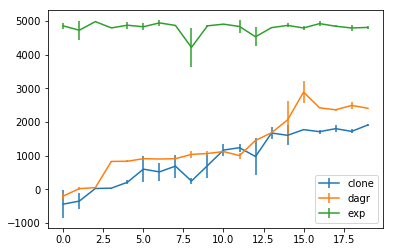

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.errorbar(
    range(len(stats)),
    [s['cloner_mean'] for s in stats],
    [s['cloner_std'] for s in stats])

plt.errorbar(
    range(len(stats)),
    [s['dagr_mean'] for s in stats],
    [s['dagr_std'] for s in stats])

plt.errorbar(
    range(len(stats)),
    [s['expr_mean'] for s in stats],
    [s['expr_std'] for s in stats])

plt.legend(['clone', 'dagr', 'exp'])